In [1]:
import numpy as np
import torch
import torch.nn as nn
import torch.optim as optim
import pandas as pd
import pickle

In [3]:
X_train = pickle.load(open('../Data/X_train.pkl', 'rb'))
y_train = pickle.load(open('../Data/y_train.pkl', 'rb'))
X_test = pickle.load(open('../Data/X_test.pkl', 'rb'))
y_test = pickle.load(open('../Data/y_test.pkl', 'rb'))

print(X_train.shape)
print(y_train.shape)
print(X_test.shape)
print(y_test.shape)

(329, 20530)
(329,)
(83, 20530)
(83,)


In [4]:
# standardize the data
from sklearn.preprocessing import StandardScaler

scaler = StandardScaler()
scaler.fit(X_train)
X_train = scaler.transform(X_train)
X_test = scaler.transform(X_test)

print(X_train)

[[-0.48855657  0.12112708 -0.33372349 ...  0.04735987  0.50779996
  -0.02217494]
 [ 0.83092164  1.17948768 -0.33372349 ...  0.18754437  0.77965228
  -0.17205193]
 [-1.861054   -0.69352094 -0.33372349 ... -0.35346398 -2.00005787
   3.63814136]
 ...
 [ 1.50287947  0.88173571  0.1048791  ... -0.33180584  0.91213697
  -0.14253948]
 [-0.06583194  0.60359346 -0.33372349 ...  0.20030191  0.44110666
  -1.31512921]
 [-0.87784052 -0.01478846 -0.33372349 ...  0.12805867  1.46177518
  -0.6430939 ]]


In [5]:
device = torch.device('cuda:0' if torch.cuda.is_available() else 'cpu')
device

device(type='cpu')

In [6]:
X_train = torch.tensor(X_train, dtype=torch.float32)
X_test = torch.tensor(X_test, dtype=torch.float32)
y_train = torch.tensor(y_train, dtype=torch.float32)
y_test = torch.tensor(y_test, dtype=torch.float32)

X_train.shape, X_test.shape, y_train.shape, y_test.shape

(torch.Size([329, 20530]),
 torch.Size([83, 20530]),
 torch.Size([329]),
 torch.Size([83]))

## Define the model

In [27]:
class DLModel(nn.Module):
    def __init__(self, input_size):
        super(DLModel, self).__init__()
        self.layers = nn.Sequential(
            nn.Linear(input_size, 1024, bias=True),
            nn.ReLU(),
            nn.Linear(1024, 64, bias=True),
            nn.ReLU(),
            nn.Linear(64, 1, bias=True),
            nn.Sigmoid()
        )

    def forward(self, x):
        return self.layers(x)

In [47]:
# model parameters
input_size = 20530
learning_rate = 0.1
epochs = 100
batch_size = 64

In [29]:
from tqdm import tqdm
from sklearn.metrics import roc_auc_score

# Instantiate the model
model = DLModel(input_size).to(device)

# Define loss function and optimizer
criterion = nn.BCELoss()
optimizer = optim.Adam(model.parameters(), lr=0.001)

# Train the model
for epoch in tqdm(range(epochs)):
    for i in range(0, len(X_train), batch_size):
        X_batch = X_train[i:i+batch_size]
        y_batch = y_train[i:i+batch_size]
        
        y_pred = model(X_batch)
        loss = criterion(y_pred, y_batch.view(-1, 1))
        
        optimizer.zero_grad()
        loss.backward()
        optimizer.step()


print(model.eval())
# test accuracy
with torch.no_grad():
    y_pred = model(X_test)
    y_pred = y_pred.round()
    acc = y_pred.eq(y_test.view_as(y_pred)).sum() / float(len(y_test))
    print(f'Test accuracy: {acc:.4f}')

# test auc
with torch.no_grad():
    y_pred = model(X_test)
    y_pred = y_pred.round()
    auc = roc_auc_score(y_test, y_pred)
    print(f'Test AUC: {auc:.4f}')

100%|██████████| 100/100 [00:46<00:00,  2.16it/s]

DLModel(
  (layers): Sequential(
    (0): Linear(in_features=20530, out_features=1024, bias=True)
    (1): ReLU()
    (2): Linear(in_features=1024, out_features=64, bias=True)
    (3): ReLU()
    (4): Linear(in_features=64, out_features=1, bias=True)
    (5): Sigmoid()
  )
)
Test accuracy: 0.9157
Test AUC: 0.9002


In [14]:
model_1 = {
    'model': model,
    'input_size': input_size,
    'learning_rate': learning_rate,
    'epochs': epochs,
    'batch_size': batch_size,
    'n_splits': n_splits,
    'acc': acc,
    'auc': auc
}

pickle.dump(model_1, open('DL_model_1.pkl', 'wb'))

## Define a little deeper model

In [15]:
class DLModel(nn.Module):
    def __init__(self, input_size):
        super(DLModel, self).__init__()
        self.layers = nn.Sequential(
            nn.Linear(input_size, 1024),
            nn.ReLU(),
            nn.Linear(1024, 256),
            nn.ReLU(),
            nn.Linear(256, 64),
            nn.ReLU(),
            nn.Linear(64, 1),
            nn.Sigmoid()
        )

    def forward(self, x):
        return self.layers(x)

In [16]:
from tqdm import tqdm

# Instantiate the model
model = DLModel(input_size).to(device)

# Define loss function and optimizer
criterion = nn.BCELoss()
optimizer = optim.Adam(model.parameters(), lr=0.001)

# Train the model
for epoch in tqdm(range(epochs)):
    for i in range(0, len(X_train), batch_size):
        X_batch = X_train[i:i+batch_size]
        y_batch = y_train[i:i+batch_size]
        
        y_pred = model(X_batch)
        loss = criterion(y_pred, y_batch.view(-1, 1))
        
        optimizer.zero_grad()
        loss.backward()
        optimizer.step()

# test accuracy
with torch.no_grad():
    y_pred = model(X_test)
    y_pred = y_pred.round()
    acc = y_pred.eq(y_test.view_as(y_pred)).sum() / float(len(y_test))
    print(f'Test accuracy: {acc:.4f}')

# test auc
with torch.no_grad():
    y_pred = model(X_test)
    y_pred = y_pred.round()
    auc = roc_auc_score(y_test, y_pred)
    print(f'Test AUC: {auc:.4f}')

100%|██████████| 100/100 [01:21<00:00,  1.23it/s]

Test accuracy: 0.9277
Test AUC: 0.9314


In [17]:
model_1 = {
    'model': model,
    'input_size': input_size,
    'learning_rate': learning_rate,
    'epochs': epochs,
    'batch_size': batch_size,
    'n_splits': n_splits,
    'acc': acc,
    'auc': auc
}

pickle.dump(model_1, open('DL_model_2.pkl', 'wb'))

In [21]:
model = pickle.load(open('DL_model_2.pkl', 'rb'))
print(model)

{'model': DLModel(
  (layers): Sequential(
    (0): Linear(in_features=20530, out_features=1024, bias=True)
    (1): ReLU()
    (2): Linear(in_features=1024, out_features=256, bias=True)
    (3): ReLU()
    (4): Linear(in_features=256, out_features=64, bias=True)
    (5): ReLU()
    (6): Linear(in_features=64, out_features=1, bias=True)
    (7): Sigmoid()
  )
), 'input_size': 20530, 'learning_rate': 0.01, 'epochs': 100, 'batch_size': 32, 'n_splits': 5, 'acc': tensor(0.9277), 'auc': 0.9314365671641791}


## Define a more deeper model

In [18]:
class DLModel(nn.Module):
    def __init__(self, input_size):
        super(DLModel, self).__init__()
        self.layers = nn.Sequential(
            nn.Linear(input_size, 1024),
            nn.ReLU(),
            nn.Linear(1024, 1024),
            nn.ReLU(),
            nn.Linear(1024, 256),
            nn.ReLU(),
            nn.Linear(256, 32),
            nn.ReLU(),
            nn.Linear(32, 1),
            nn.Sigmoid()
        )

    def forward(self, x):
        return self.layers(x)

In [19]:
from tqdm import tqdm

# Instantiate the model
model = DLModel(input_size).to(device)

# Define loss function and optimizer
criterion = nn.BCELoss()
optimizer = optim.Adam(model.parameters(), lr=0.001)

# Train the model
for epoch in tqdm(range(epochs)):
    for i in range(0, len(X_train), batch_size):
        X_batch = X_train[i:i+batch_size]
        y_batch = y_train[i:i+batch_size]
        
        y_pred = model(X_batch)
        loss = criterion(y_pred, y_batch.view(-1, 1))
        
        optimizer.zero_grad()
        loss.backward()
        optimizer.step()

# test accuracy
with torch.no_grad():
    y_pred = model(X_test)
    y_pred = y_pred.round()
    acc = y_pred.eq(y_test.view_as(y_pred)).sum() / float(len(y_test))
    print(f'Test accuracy: {acc:.4f}')

# test auc
with torch.no_grad():
    y_pred = model(X_test)
    y_pred = y_pred.round()
    auc = roc_auc_score(y_test, y_pred)
    print(f'Test AUC: {auc:.4f}')

100%|██████████| 100/100 [01:36<00:00,  1.04it/s]

Test accuracy: 0.9036
Test AUC: 0.8689


In [20]:
model_1 = {
    'model': model,
    'input_size': input_size,
    'learning_rate': learning_rate,
    'epochs': epochs,
    'batch_size': batch_size,
    'n_splits': n_splits,
    'acc': acc,
    'auc': auc
}

pickle.dump(model_1, open('DL_model_3.pkl', 'wb'))

## Regularized model

In [48]:
class RegularizedNN(nn.Module):
    def __init__(self, input_size, l2_penalty=1e-4):
        super(RegularizedNN, self).__init__()
        self.fc1 = nn.Linear(input_size, 1024, bias=True)
        self.bn1 = nn.BatchNorm1d(1024)
        self.relu = nn.ReLU()
        self.fc2 = nn.Linear(1024, 256, bias=True)
        self.bn2 = nn.BatchNorm1d(256)
        self.relu = nn.ReLU()
        self.fc3 = nn.Linear(256, 64, bias=True)
        self.bn3 = nn.BatchNorm1d(64)
        self.relu = nn.ReLU()
        self.fc4 = nn.Linear(64, 1, bias=True)
        self.sigmoid = nn.Sigmoid()
        
        # Apply L2 regularization to the weight parameters of linear layers
        self.fc1.weight.data = nn.Parameter(self.fc1.weight.data, requires_grad=True)
        self.fc2.weight.data = nn.Parameter(self.fc2.weight.data, requires_grad=True)
        self.fc3.weight.data = nn.Parameter(self.fc3.weight.data, requires_grad=True)
        self.fc4.weight.data = nn.Parameter(self.fc4.weight.data, requires_grad=True)
        
        # Set the weight decay for L2 regularization
        self.l2_penalty = l2_penalty

    def forward(self, x):
        x = self.fc1(x)
        x = self.relu(x)
        x = self.fc2(x)
        x = self.relu(x)
        x = self.fc3(x)
        x = self.relu(x)
        x = self.fc4(x)
        x = self.sigmoid(x)
        return x

In [49]:
from tqdm import tqdm

model = RegularizedNN(input_size).to(device)

criterion = nn.BCELoss()
optimizer = optim.Adam(model.parameters(), lr=0.001)

for epoch in tqdm(range(epochs)):
    for i in range(0, len(X_train), batch_size):
        X_batch = X_train[i:i+batch_size]
        y_batch = y_train[i:i+batch_size]
        
        y_pred = model(X_batch)
        loss = criterion(y_pred, y_batch.view(-1, 1))
        
        optimizer.zero_grad()
        loss.backward()
        optimizer.step()

# test accuracy
with torch.no_grad():
    y_pred = model(X_test)
    y_pred = y_pred.round()
    acc = y_pred.eq(y_test.view_as(y_pred)).sum() / float(len(y_test))
    print(f'Test accuracy: {acc:.4f}')

# test auc
with torch.no_grad():
    y_pred = model(X_test)
    y_pred = y_pred.round()
    auc = roc_auc_score(y_test, y_pred)
    print(f'Test AUC: {auc:.4f}')

100%|██████████| 100/100 [00:47<00:00,  2.09it/s]

Test accuracy: 0.9157
Test AUC: 0.9002


In [43]:
model_4 = {
    'model': model,
    'input_size': input_size,
    'learning_rate': learning_rate,
    'epochs': epochs,
    'batch_size': batch_size,
    'acc': acc,
    'auc': auc
}

pickle.dump(model_4, open('DL_model_4.pkl', 'wb'))

## Exhausive search

In [56]:
from tqdm import tqdm

class DLModel(nn.Module):
    def __init__(self, input_size):
        super(DLModel, self).__init__()
        self.layers = nn.Sequential(
            nn.Linear(input_size, 1024),
            nn.ReLU(),
            nn.Linear(1024, 256),
            nn.ReLU(),
            nn.Linear(256, 64),
            nn.ReLU(),
            nn.Linear(64, 1),
            nn.Sigmoid()
        )

    def forward(self, x):
        return self.layers(x)
    
    def fit(self, X, y, epochs, batch_size, lr):
        criterion = nn.BCELoss()
        optimizer = optim.Adam(self.parameters(), lr=0.001)
        
        for epoch in tqdm(range(epochs)):
        # for epoch in range(epochs):
            for i in range(0, X.shape[0], batch_size):

                X_batch = X[i:i+batch_size]
                y_batch = y[i:i+batch_size]

                y_pred = self(X_batch)
                loss = criterion(y_pred, y_batch.view(-1, 1))

                optimizer.zero_grad()
                loss.backward()
                optimizer.step()

            # print('Epoch: {}, Loss: {}'.format(epoch, loss.item()))

    def predict(self, X):
        y_pred = self(X)
        return y_pred

In [61]:
import itertools
from sklearn.metrics import roc_auc_score, accuracy_score

# Define the hyperparameter grid
epochs_grid = [5, 10, 20, 30, 50]
lr_grid = [0.001, 0.01, 0.1]
batch_size_grid = [16, 32, 64, 128]

# convert to df
df = pd.DataFrame(list(itertools.product(epochs_grid, lr_grid, batch_size_grid)), columns=['epochs', 'lr', 'batch_size'])
df['acc'] = np.nan
df['auc'] = np.nan

for epochs, lr, batch_size in itertools.product(epochs_grid, lr_grid, batch_size_grid):
    model = DLModel(input_size=X_train.shape[1])
    model.fit(X_train, y_train, epochs=epochs, batch_size=batch_size, lr=lr)

    y_pred = model.predict(X_test)
    y_pred = y_pred.round()
    y_pred = y_pred.cpu().detach().numpy()
    acc = accuracy_score(y_test, y_pred)
    auc = roc_auc_score(y_test, y_pred)

    df.loc[(df['epochs'] == epochs) & (df['lr'] == lr) & (df['batch_size'] == batch_size), 'acc'] = acc
    df.loc[(df['epochs'] == epochs) & (df['lr'] == lr) & (df['batch_size'] == batch_size), 'auc'] = auc

    print('Epochs: {}, LR: {}, Batch Size: {}, Accuracy: {}, AUC: {}'.format(epochs, lr, batch_size, acc, auc))

100%|██████████| 5/5 [00:07<00:00,  1.54s/it]


Epochs: 5, LR: 0.001, Batch Size: 16, Accuracy: 0.9036144578313253, AUC: 0.8451492537313433


100%|██████████| 5/5 [00:04<00:00,  1.21it/s]


Epochs: 5, LR: 0.001, Batch Size: 32, Accuracy: 0.9156626506024096, AUC: 0.8763992537313433


100%|██████████| 5/5 [00:02<00:00,  2.15it/s]


Epochs: 5, LR: 0.001, Batch Size: 64, Accuracy: 0.927710843373494, AUC: 0.9314365671641791


100%|██████████| 5/5 [00:01<00:00,  3.91it/s]


Epochs: 5, LR: 0.001, Batch Size: 128, Accuracy: 0.9036144578313253, AUC: 0.8927238805970149


100%|██████████| 5/5 [00:07<00:00,  1.59s/it]


Epochs: 5, LR: 0.01, Batch Size: 16, Accuracy: 0.9036144578313253, AUC: 0.8927238805970149


100%|██████████| 5/5 [00:04<00:00,  1.17it/s]


Epochs: 5, LR: 0.01, Batch Size: 32, Accuracy: 0.927710843373494, AUC: 0.9314365671641791


100%|██████████| 5/5 [00:02<00:00,  2.10it/s]


Epochs: 5, LR: 0.01, Batch Size: 64, Accuracy: 0.9036144578313253, AUC: 0.8927238805970149


100%|██████████| 5/5 [00:01<00:00,  3.40it/s]


Epochs: 5, LR: 0.01, Batch Size: 128, Accuracy: 0.9156626506024096, AUC: 0.8526119402985075


100%|██████████| 5/5 [00:07<00:00,  1.43s/it]


Epochs: 5, LR: 0.1, Batch Size: 16, Accuracy: 0.9397590361445783, AUC: 0.9388992537313433


100%|██████████| 5/5 [00:03<00:00,  1.35it/s]


Epochs: 5, LR: 0.1, Batch Size: 32, Accuracy: 0.9036144578313253, AUC: 0.8451492537313433


100%|██████████| 5/5 [00:02<00:00,  2.38it/s]


Epochs: 5, LR: 0.1, Batch Size: 64, Accuracy: 0.927710843373494, AUC: 0.9314365671641791


100%|██████████| 5/5 [00:01<00:00,  4.49it/s]


Epochs: 5, LR: 0.1, Batch Size: 128, Accuracy: 0.9036144578313253, AUC: 0.8451492537313433


100%|██████████| 10/10 [00:13<00:00,  1.37s/it]


Epochs: 10, LR: 0.001, Batch Size: 16, Accuracy: 0.9156626506024096, AUC: 0.8763992537313433


100%|██████████| 10/10 [00:07<00:00,  1.34it/s]


Epochs: 10, LR: 0.001, Batch Size: 32, Accuracy: 0.891566265060241, AUC: 0.8376865671641791


100%|██████████| 10/10 [00:04<00:00,  2.41it/s]


Epochs: 10, LR: 0.001, Batch Size: 64, Accuracy: 0.9156626506024096, AUC: 0.9001865671641791


100%|██████████| 10/10 [00:02<00:00,  4.46it/s]


Epochs: 10, LR: 0.001, Batch Size: 128, Accuracy: 0.927710843373494, AUC: 0.9314365671641791


100%|██████████| 10/10 [00:13<00:00,  1.37s/it]


Epochs: 10, LR: 0.01, Batch Size: 16, Accuracy: 0.927710843373494, AUC: 0.9076492537313433


100%|██████████| 10/10 [00:07<00:00,  1.38it/s]


Epochs: 10, LR: 0.01, Batch Size: 32, Accuracy: 0.891566265060241, AUC: 0.8614738805970149


100%|██████████| 10/10 [00:04<00:00,  2.41it/s]


Epochs: 10, LR: 0.01, Batch Size: 64, Accuracy: 0.9156626506024096, AUC: 0.9001865671641791


100%|██████████| 10/10 [00:02<00:00,  4.52it/s]


Epochs: 10, LR: 0.01, Batch Size: 128, Accuracy: 0.9156626506024096, AUC: 0.8763992537313433


100%|██████████| 10/10 [00:13<00:00,  1.36s/it]


Epochs: 10, LR: 0.1, Batch Size: 16, Accuracy: 0.927710843373494, AUC: 0.9552238805970149


100%|██████████| 10/10 [00:07<00:00,  1.36it/s]


Epochs: 10, LR: 0.1, Batch Size: 32, Accuracy: 0.9156626506024096, AUC: 0.8763992537313433


100%|██████████| 10/10 [00:04<00:00,  2.44it/s]


Epochs: 10, LR: 0.1, Batch Size: 64, Accuracy: 0.891566265060241, AUC: 0.8614738805970149


100%|██████████| 10/10 [00:02<00:00,  4.49it/s]


Epochs: 10, LR: 0.1, Batch Size: 128, Accuracy: 0.8795180722891566, AUC: 0.8302238805970149


100%|██████████| 20/20 [00:27<00:00,  1.39s/it]


Epochs: 20, LR: 0.001, Batch Size: 16, Accuracy: 0.9156626506024096, AUC: 0.9001865671641791


100%|██████████| 20/20 [00:14<00:00,  1.38it/s]


Epochs: 20, LR: 0.001, Batch Size: 32, Accuracy: 0.9036144578313253, AUC: 0.8689365671641791


100%|██████████| 20/20 [00:08<00:00,  2.46it/s]


Epochs: 20, LR: 0.001, Batch Size: 64, Accuracy: 0.9156626506024096, AUC: 0.9001865671641791


100%|██████████| 20/20 [00:04<00:00,  4.49it/s]


Epochs: 20, LR: 0.001, Batch Size: 128, Accuracy: 0.927710843373494, AUC: 0.9314365671641791


100%|██████████| 20/20 [00:27<00:00,  1.40s/it]


Epochs: 20, LR: 0.01, Batch Size: 16, Accuracy: 0.927710843373494, AUC: 0.9076492537313433


100%|██████████| 20/20 [00:15<00:00,  1.33it/s]


Epochs: 20, LR: 0.01, Batch Size: 32, Accuracy: 0.927710843373494, AUC: 0.9314365671641791


100%|██████████| 20/20 [00:08<00:00,  2.35it/s]


Epochs: 20, LR: 0.01, Batch Size: 64, Accuracy: 0.927710843373494, AUC: 0.9314365671641791


100%|██████████| 20/20 [00:04<00:00,  4.34it/s]


Epochs: 20, LR: 0.01, Batch Size: 128, Accuracy: 0.9156626506024096, AUC: 0.9001865671641791


100%|██████████| 20/20 [00:28<00:00,  1.43s/it]


Epochs: 20, LR: 0.1, Batch Size: 16, Accuracy: 0.9036144578313253, AUC: 0.8927238805970149


100%|██████████| 20/20 [00:15<00:00,  1.32it/s]


Epochs: 20, LR: 0.1, Batch Size: 32, Accuracy: 0.927710843373494, AUC: 0.9076492537313433


100%|██████████| 20/20 [00:09<00:00,  2.20it/s]


Epochs: 20, LR: 0.1, Batch Size: 64, Accuracy: 0.9036144578313253, AUC: 0.8689365671641791


100%|██████████| 20/20 [00:05<00:00,  3.63it/s]


Epochs: 20, LR: 0.1, Batch Size: 128, Accuracy: 0.9156626506024096, AUC: 0.9001865671641791


100%|██████████| 30/30 [00:43<00:00,  1.44s/it]


Epochs: 30, LR: 0.001, Batch Size: 16, Accuracy: 0.927710843373494, AUC: 0.9076492537313433


100%|██████████| 30/30 [00:23<00:00,  1.30it/s]


Epochs: 30, LR: 0.001, Batch Size: 32, Accuracy: 0.9156626506024096, AUC: 0.9001865671641791


100%|██████████| 30/30 [00:12<00:00,  2.37it/s]


Epochs: 30, LR: 0.001, Batch Size: 64, Accuracy: 0.9036144578313253, AUC: 0.8927238805970149


100%|██████████| 30/30 [00:06<00:00,  4.30it/s]


Epochs: 30, LR: 0.001, Batch Size: 128, Accuracy: 0.8674698795180723, AUC: 0.7989738805970149


100%|██████████| 30/30 [00:42<00:00,  1.42s/it]


Epochs: 30, LR: 0.01, Batch Size: 16, Accuracy: 0.927710843373494, AUC: 0.9076492537313433


100%|██████████| 30/30 [00:22<00:00,  1.34it/s]


Epochs: 30, LR: 0.01, Batch Size: 32, Accuracy: 0.9156626506024096, AUC: 0.9001865671641791


100%|██████████| 30/30 [00:13<00:00,  2.29it/s]


Epochs: 30, LR: 0.01, Batch Size: 64, Accuracy: 0.891566265060241, AUC: 0.8376865671641791


100%|██████████| 30/30 [00:06<00:00,  4.31it/s]


Epochs: 30, LR: 0.01, Batch Size: 128, Accuracy: 0.9036144578313253, AUC: 0.8689365671641791


100%|██████████| 30/30 [00:43<00:00,  1.44s/it]


Epochs: 30, LR: 0.1, Batch Size: 16, Accuracy: 0.927710843373494, AUC: 0.9076492537313433


100%|██████████| 30/30 [00:22<00:00,  1.32it/s]


Epochs: 30, LR: 0.1, Batch Size: 32, Accuracy: 0.9156626506024096, AUC: 0.9001865671641791


100%|██████████| 30/30 [00:12<00:00,  2.34it/s]


Epochs: 30, LR: 0.1, Batch Size: 64, Accuracy: 0.9036144578313253, AUC: 0.8451492537313433


100%|██████████| 30/30 [00:07<00:00,  4.28it/s]


Epochs: 30, LR: 0.1, Batch Size: 128, Accuracy: 0.927710843373494, AUC: 0.9314365671641791


100%|██████████| 50/50 [01:16<00:00,  1.54s/it]


Epochs: 50, LR: 0.001, Batch Size: 16, Accuracy: 0.927710843373494, AUC: 0.9076492537313433


100%|██████████| 50/50 [00:37<00:00,  1.34it/s]


Epochs: 50, LR: 0.001, Batch Size: 32, Accuracy: 0.9156626506024096, AUC: 0.9239738805970149


100%|██████████| 50/50 [00:20<00:00,  2.38it/s]


Epochs: 50, LR: 0.001, Batch Size: 64, Accuracy: 0.9156626506024096, AUC: 0.8763992537313433


100%|██████████| 50/50 [00:11<00:00,  4.39it/s]


Epochs: 50, LR: 0.001, Batch Size: 128, Accuracy: 0.9156626506024096, AUC: 0.9001865671641791


100%|██████████| 50/50 [01:12<00:00,  1.44s/it]


Epochs: 50, LR: 0.01, Batch Size: 16, Accuracy: 0.9156626506024096, AUC: 0.9001865671641791


100%|██████████| 50/50 [00:38<00:00,  1.31it/s]


Epochs: 50, LR: 0.01, Batch Size: 32, Accuracy: 0.9156626506024096, AUC: 0.9001865671641791


100%|██████████| 50/50 [00:21<00:00,  2.35it/s]


Epochs: 50, LR: 0.01, Batch Size: 64, Accuracy: 0.9036144578313253, AUC: 0.8689365671641791


100%|██████████| 50/50 [00:11<00:00,  4.41it/s]


Epochs: 50, LR: 0.01, Batch Size: 128, Accuracy: 0.927710843373494, AUC: 0.9314365671641791


100%|██████████| 50/50 [01:15<00:00,  1.52s/it]


Epochs: 50, LR: 0.1, Batch Size: 16, Accuracy: 0.9036144578313253, AUC: 0.8451492537313433


100%|██████████| 50/50 [00:37<00:00,  1.35it/s]


Epochs: 50, LR: 0.1, Batch Size: 32, Accuracy: 0.9156626506024096, AUC: 0.9001865671641791


100%|██████████| 50/50 [00:21<00:00,  2.38it/s]


Epochs: 50, LR: 0.1, Batch Size: 64, Accuracy: 0.9156626506024096, AUC: 0.9239738805970149


100%|██████████| 50/50 [00:11<00:00,  4.39it/s]

Epochs: 50, LR: 0.1, Batch Size: 128, Accuracy: 0.9156626506024096, AUC: 0.9001865671641791


In [62]:
df.head()

,epochs,lr,batch_size,acc,auc
0,5,0.001,16,0.903614,0.845149
1,5,0.001,32,0.915663,0.876399
2,5,0.001,64,0.927711,0.931437
3,5,0.001,128,0.903614,0.892724
4,5,0.010,16,0.903614,0.892724


In [65]:
# exctract the row of best accuracy
best_acc = df.loc[df['acc'].idxmax()]
best_acc

epochs         5.000000
lr             0.100000
batch_size    16.000000
acc            0.939759
auc            0.938899
Name: 8, dtype: float64

In [66]:
# exctract the row of best auc
best_auc = df.loc[df['auc'].idxmax()]
best_auc

epochs        10.000000
lr             0.100000
batch_size    16.000000
acc            0.927711
auc            0.955224
Name: 20, dtype: float64

In [67]:
df.to_csv('DL_model_params.csv', index=False)

In [68]:
# extract the rows of best 5 auc
best_5_auc = df.nlargest(5, 'auc')
best_5_auc

,epochs,lr,batch_size,acc,auc
20,10,0.100,16,0.927711,0.955224
8,5,0.100,16,0.939759,0.938899
2,5,0.001,64,0.927711,0.931437
5,5,0.010,32,0.927711,0.931437
10,5,0.100,64,0.927711,0.931437


# Demo

In [10]:
from tqdm import tqdm

class DLModel(nn.Module):
    def __init__(self, input_size):
        super(DLModel, self).__init__()
        self.layers = nn.Sequential(
            nn.Linear(input_size, 1024),
            nn.ReLU(),
            nn.Linear(1024, 256),
            nn.ReLU(),
            nn.Linear(256, 64),
            nn.ReLU(),
            nn.Linear(64, 1),
            nn.Sigmoid()
        )

    def forward(self, x):
        return self.layers(x)
    
    def fit(self, X, y, epochs, batch_size, lr):
        criterion = nn.BCELoss()
        optimizer = optim.Adam(self.parameters(), lr=0.001)
        
        for epoch in tqdm(range(epochs)):
        # for epoch in range(epochs):
            for i in range(0, X.shape[0], batch_size):

                X_batch = X[i:i+batch_size]
                y_batch = y[i:i+batch_size]

                y_pred = self(X_batch)
                loss = criterion(y_pred, y_batch.view(-1, 1))

                optimizer.zero_grad()
                loss.backward()
                optimizer.step()

            # print('Epoch: {}, Loss: {}'.format(epoch, loss.item()))

    def predict(self, X):
        y_pred = self(X)
        return y_pred

In [11]:
model = DLModel(input_size=X_train.shape[1])
model.fit(X_train, y_train, epochs=5, batch_size=16, lr=0.1)

y_pred = model.predict(X_test)
y_pred = y_pred.round()
y_pred = y_pred.cpu().detach().numpy()

100%|██████████| 5/5 [00:07<00:00,  1.49s/it]


In [12]:
from sklearn.metrics import accuracy_score, roc_auc_score

acc = accuracy_score(y_test, y_pred)
auc = roc_auc_score(y_test, y_pred)

print('Accuracy: {}, AUC: {}'.format(acc, auc))

Accuracy: 0.927710843373494, AUC: 0.9314365671641791


In [14]:
y_pred_train = model.predict(X_train)

y_pred_train = y_pred_train.round()
y_pred_train = y_pred_train.cpu().detach().numpy()

acc_train = accuracy_score(y_train, y_pred_train)
print('Accuracy: {}'.format(acc_train))

Accuracy: 0.9969604863221885


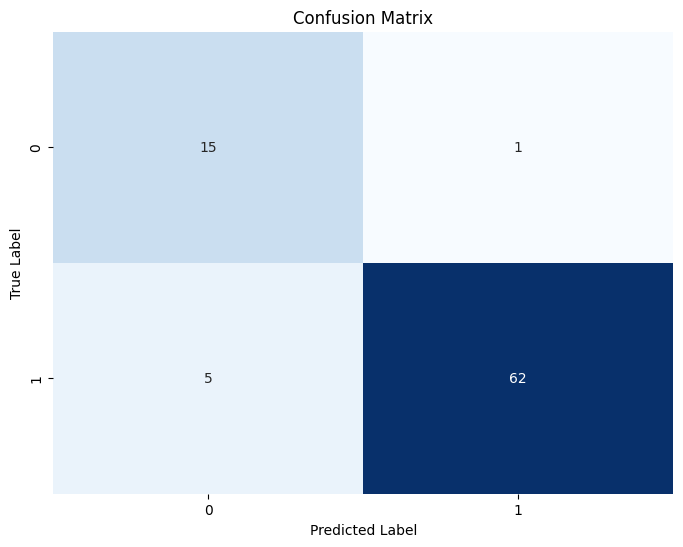

              precision    recall  f1-score   support

         0.0       0.75      0.94      0.83        16
         1.0       0.98      0.93      0.95        67

    accuracy                           0.93        83
   macro avg       0.87      0.93      0.89        83
weighted avg       0.94      0.93      0.93        83



In [13]:
from sklearn.metrics import confusion_matrix, classification_report

import numpy as np
import seaborn as sns
import matplotlib.pyplot as plt

# plot confusion matrix
# cm = np.array([[10, 6], [2, 65]])
cm = confusion_matrix(y_test, y_pred)
plt.figure(figsize=(8, 6))
plt.title("Confusion Matrix")
sns.heatmap(cm, annot=True, cmap='Blues', fmt='g', cbar=False)
plt.xlabel('Predicted Label')
plt.ylabel('True Label')
plt.show()

print(classification_report(y_test, y_pred))